# MinHash

More details on Universal Hashing: https://en.wikipedia.org/wiki/Universal_hashing

# Plot the threshold curve

The curve is based on the function: 
$$
f_{r, b}(t) = 1 - (1-t^r)^b
$$

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [12]:
R = 15
B = 40

In [13]:
def f(t, r=R, b=B):
    return 1.0 - (1.0 - t**r)**b

In [14]:
for i in range(11):
    t = i / 10.0
    print('f({:.02f}) = {:.13f}'.format(t, f(t)))

f(0.00) = 0.0000000000000
f(0.10) = 0.0000000000000
f(0.20) = 0.0000000013107
f(0.30) = 0.0000005739561
f(0.40) = 0.0000429487737
f(0.50) = 0.0012199769741
f(0.60) = 0.0186359842571
f(0.70) = 0.1733341191380
f(0.80) = 0.7613435484247
f(0.90) = 0.9999010987377
f(1.00) = 1.0000000000000


In [15]:
vfunct = np.vectorize(f)

num = 100 
#num = 10

X = np.array([i/num for i in range(num+1) ])
Y = vfunct(X)

#print(X)
#print(Y)


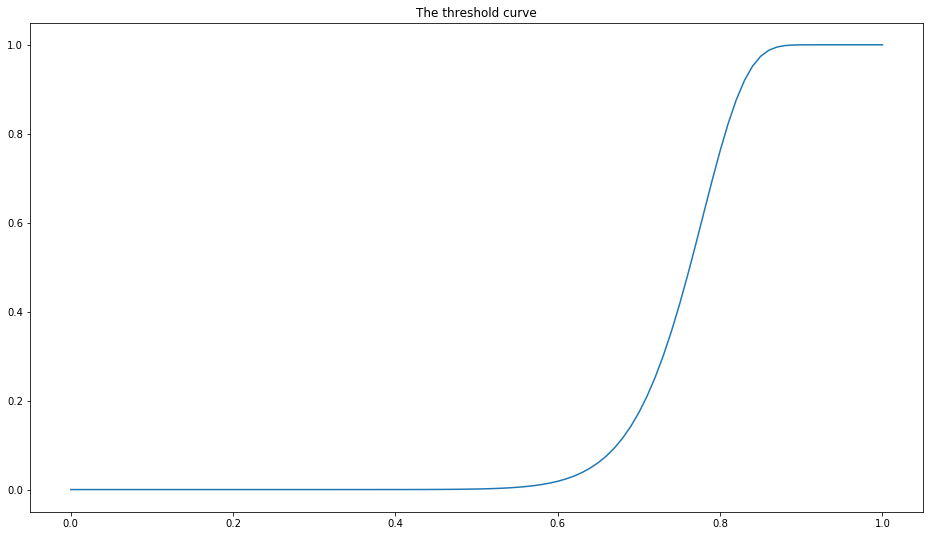

In [16]:
plt.figure(figsize=(16,9)) 
plt.title('The threshold curve')
plt.plot(X, Y)

Now let's wrap all in one function. 

In [25]:
def plot_curves(rs, bs, num=100):
    params = [(r, b) for r in rs for b in bs]
    
    plt.figure(figsize=(16,9)) 
    plt.title('The threshold curve')

    
    for r, b in params:
        X = np.array([i/num for i in range(num+1) ])
        Y = np.array([f(x, r, b) for x in X])
        plt.plot(X, Y, label='r={}, b={}'.format(r, b))
        plt.legend()


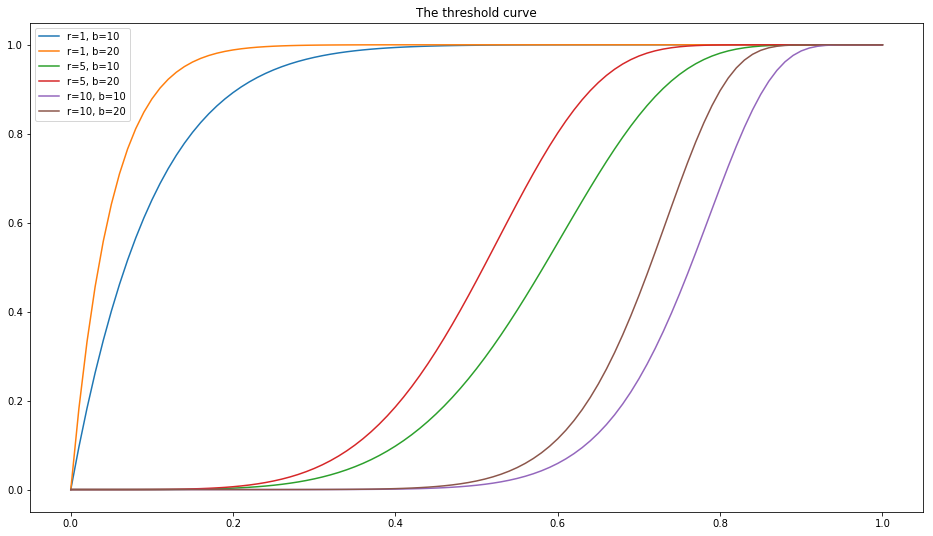

In [26]:
plot_curves([1, 5, 10], [10, 20])

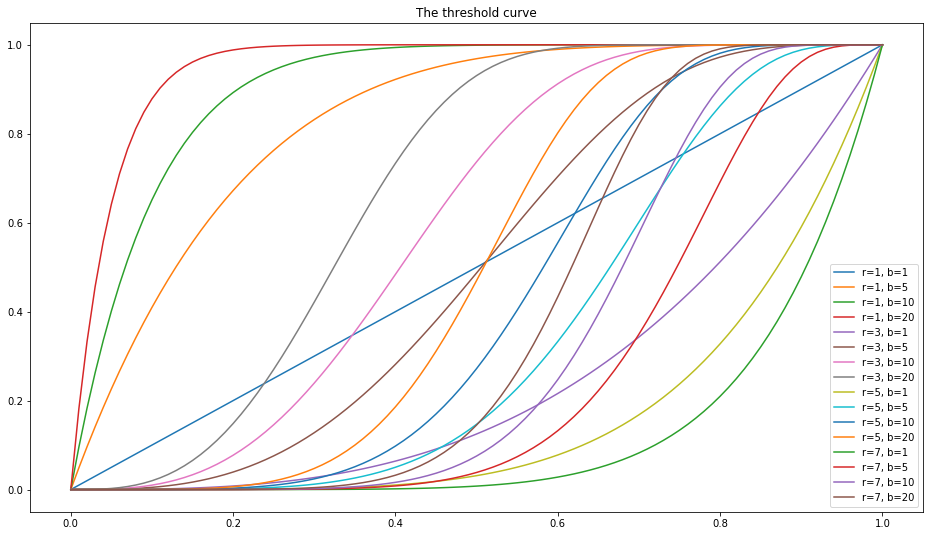

In [27]:
plot_curves([1, 3, 5, 7], [1, 5, 10, 20])

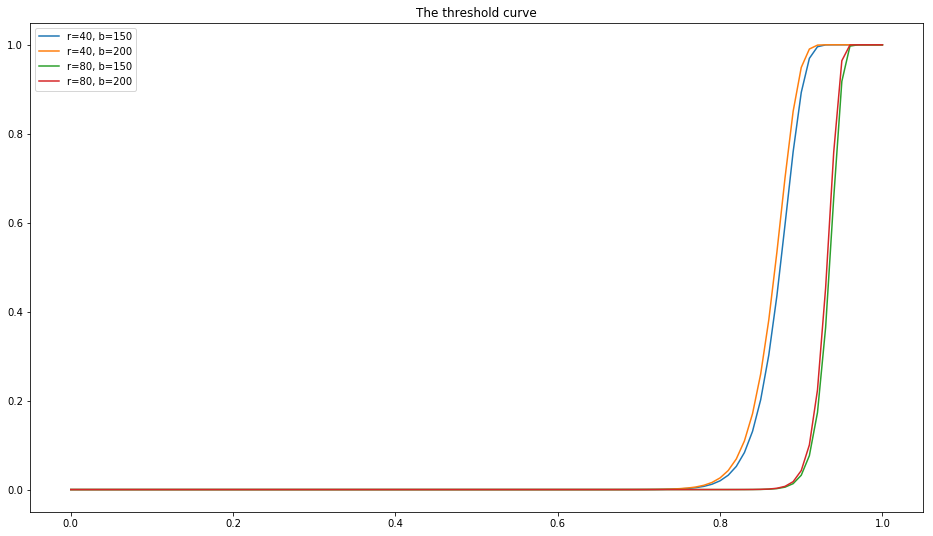

In [30]:
plot_curves([1], [150,200])

# Implementation

In [30]:
import random

# global constants
U = 5
M = 9
P = 31
# K = 3 # how many hashes needed in 
K = 100 # K is roughly O(1 / relative_accuracy^2), so a fairly large number is needed to get to 10% relative error.
#rand_seed = 42 # to make sure the results are repeatable
rand_seed = None
#DEBUG = True
DEBUG = False

# global variables
coeffs = None # coefficients for the hash functions


def init_coeffs():
    random.seed(rand_seed)
    coeffs_ = [(random.randint(0, P), random.randint(1, P)) for i in range(K)]
    return coeffs_

def dump_hash_functions():
    for i in range(K):
        print("h_{I}(x) = ({A}*x + {B} mod {P}) mod {M}".format(I = i, A = coeffs[i][0], 
                                                                B = coeffs[i][1], P = P, M = M))

def h(i, x):
    return ((coeffs[i][0] * x + coeffs[i][1]) % P) % M 

def sketch(set_):
    sig = []
    for i in range(K):
        hashed_values = [h(i, e) for e in set_]
        min_idx_pos = hashed_values.index(min(hashed_values)) # this gives the minimum indexed position

        if DEBUG: 
            print(".. set = {} \t h(e, {}) = {} \t min_elem_pos = {}".format(str(set_), i, str(hashed_values), min_idx_pos))

        sig.append(set_[min_idx_pos])
    
    return sig

def jaccard(set1, set2):
    s1, s2 = set(set1), set(set2)
    return len(s1 & s2) / len(s1 | s2)

def minhash_estimate(sigs1, sigs2):
    L = len(sigs1)
    matches = [sigs1[i] == sigs2[i] for i in range(L)]
    return matches.count(True) / L
    
## main
coeffs = init_coeffs()
# dump_hash_functions()

# S = [[0, 2, 3], [1, 4], [0, 1, 3]]
S = [[0, 2, 3, 4, 7, 8], [1, 4], [0, 1, 3, 8]]


# for i, s in enumerate(S): 
#     print("S[{}] = {}".format(i, str(s)))
sigs = [sketch(s) for s in S]
# for i, sig in enumerate(sigs): 
#     print("sketch for S[{}] = {}".format(i, str(sig)))

print("\nJaccard({}, {}) = {}".format(S[0], S[2], jaccard(S[0], S[2])))
print("MinHash estimate = {}".format(minhash_estimate(sigs[0], sigs[2])))

.. set = [0, 2, 3, 4, 7, 8] 	 h(e, 0) = [0, 0, 2, 0, 2, 4] 	 min_elem_pos = 0
.. set = [0, 2, 3, 4, 7, 8] 	 h(e, 1) = [0, 5, 3, 1, 8, 6] 	 min_elem_pos = 0
.. set = [0, 2, 3, 4, 7, 8] 	 h(e, 2) = [1, 2, 7, 3, 0, 0] 	 min_elem_pos = 4
.. set = [0, 2, 3, 4, 7, 8] 	 h(e, 3) = [3, 4, 7, 5, 0, 7] 	 min_elem_pos = 4
.. set = [0, 2, 3, 4, 7, 8] 	 h(e, 4) = [0, 8, 3, 3, 6, 1] 	 min_elem_pos = 0
.. set = [0, 2, 3, 4, 7, 8] 	 h(e, 5) = [8, 3, 1, 3, 5, 3] 	 min_elem_pos = 2
.. set = [0, 2, 3, 4, 7, 8] 	 h(e, 6) = [3, 5, 8, 2, 3, 6] 	 min_elem_pos = 3
.. set = [0, 2, 3, 4, 7, 8] 	 h(e, 7) = [7, 6, 1, 5, 3, 7] 	 min_elem_pos = 2
.. set = [0, 2, 3, 4, 7, 8] 	 h(e, 8) = [6, 4, 1, 2, 6, 3] 	 min_elem_pos = 2
.. set = [0, 2, 3, 4, 7, 8] 	 h(e, 9) = [0, 2, 1, 0, 1, 4] 	 min_elem_pos = 0
.. set = [0, 2, 3, 4, 7, 8] 	 h(e, 10) = [3, 1, 0, 8, 5, 4] 	 min_elem_pos = 2
.. set = [0, 2, 3, 4, 7, 8] 	 h(e, 11) = [0, 1, 1, 6, 3, 8] 	 min_elem_pos = 0
.. set = [0, 2, 3, 4, 7, 8] 	 h(e, 12) = [2, 2, 2, 6, 1, 1] 	 